<a href="https://colab.research.google.com/github/AshAswin/evidential_mcdo_adf_gp/blob/main/mcdo_adf_regression_toydataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn import functional as tf
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.conv import _ConvTransposeMixin
from torch.nn.modules.utils import _pair
plt.rcParams["figure.figsize"] = (15,10)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
mu = 0
sigma = 0.08
train_range = np.linspace(-3, 3, 100).reshape(-1,1)
test_range = np.linspace(-5,5,100).reshape(-1,1)
function = lambda x:np.sin(3*x)/(3*x)

In [3]:
# mu = 0
# sigma = 0.025
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-4, -1, 50).reshape(-1,1)
# range2 = np.linspace(1, 4, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-4,4,200).reshape(-1,1)
# function = lambda x:0.1*x**3

In [4]:
# mu = 0
# sigma = 0.04
# #train_data generated from two intervals in the total range
# #train_range = np.linspace(-3, 3, 100).reshape(-1,1)
# range1 = np.linspace(-6, -2, 50).reshape(-1,1)
# range2 = np.linspace(2, 6, 50).reshape(-1,1)
# train_range = np.vstack((range1,range2))

# test_range = np.linspace(-6,6,200).reshape(-1,1)
# function = lambda x:-(1+x)*np.sin(1.2*x)

In [5]:
class Data():
  def __init__(self, x, func, noise={'mu':0,'sigma':1}):
    self.x = x
    self.y_gt = func(self.x)
    self.epsilon = np.random.normal(noise['mu'],noise['sigma'],np.shape(x))
    self.y = self.y_gt + self.epsilon

def plot_results(train_data,test_data, prediction, aleatoric, epistemic,\
                 limits,v_span, legend_loc, fn_samples, title='', \
                 filename='fn'):
  #Obtain Standard Deviation  
  aleatoric = np.sqrt(aleatoric)
  epistemic = np.sqrt(epistemic)
  # plot and show learning process
  fig, ax = plt.subplots(figsize=(15,10))
  plt.cla()
  aleatoric = aleatoric[:,0]
  epistemic = epistemic[:,0]
  prediction = prediction[:,0]

  ax.fill_between(test_data.x.squeeze(), prediction + 2*aleatoric,\
                  prediction - 2*aleatoric, color='peachpuff',\
                  alpha=0.9,label='aleatoric')
  ax.fill_between(test_data.x.squeeze(), prediction +2*epistemic,\
                  prediction-2*epistemic, color='blue',alpha=0.2,\
                  label='epistemic')
  
  ax.plot(test_data.x.squeeze(), prediction, 'g-', lw=3, label='prediction',\
          color='blue')
  ax.set_title(title, fontsize=35)
  ax.set_xlabel('input', fontsize=24)
  ax.set_ylabel('output', fontsize=24)
  ax.set_xlim(limits['x'])
  ax.set_ylim(limits['y'])

  for limits in v_span:
    ax.axvspan(limits[0], limits[1], alpha=0.25, color='lightgreen',label='OOD') 
  ax.scatter(train_data.x.squeeze(), train_data.y.squeeze(), color = "green",\
             label='train_inputs')
  ax.plot(test_data.x.squeeze(),test_data.y_gt.squeeze(),lw=3,\
          label='ground truth',color='black',linestyle='--')
  plt.legend(loc=legend_loc, prop={'size':20})
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid()

In [6]:
train_data = Data(train_range, function,noise={'mu':mu, 'sigma':sigma})
test_data = Data(test_range, function,noise={'mu':mu, 'sigma':sigma})

In [7]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #hidden layers
    self.hid1 = torch.nn.Linear(1,100)
    self.dropout = torch.nn.Dropout(p=0.2)
    #output
    self.output = torch.nn.Linear(100,1)
    #initialize weights and with a normal distribution with std = 1(default)
    #zeros resp.
    torch.nn.init.normal_(self.hid1.weight)
    torch.nn.init.zeros_(self.hid1.bias)
    torch.nn.init.normal_(self.output.weight)
    torch.nn.init.zeros_(self.output.bias)
    #can be achieved using nn.Sequential also
  def forward(self, x):
    # define how every layer is linked with each other and how computation 
    #takes place
    #Activation functions
    x_dash = torch.relu(self.hid1(x))
    x_dash = self.dropout(x_dash)
    #Do not apply activation function to the output layer
    x_dash = self.output(x_dash)
    return x_dash
def calc_rmse(nn_model, X, Y):
  n_points = list(Y.size())[0]
  Y_dash = nn_model(X)
  rmse = (torch.mean((Y-Y_dash)**2))**0.5
  return rmse

In [8]:
custom_net = Net()
#Training hyperparameters
n_data_points = np.shape(train_data.x)[0]
batch_size = n_data_points
epochs = 20000
batch_per_epoch = n_data_points//batch_size
learning_rate = 1e-2
#Loss Function
loss_function = torch.nn.MSELoss()
#Optimizer
optimizer = torch.optim.Adam(custom_net.parameters(), lr=learning_rate)

epoch =      0 batch loss = 232.4714
RMSE  = 11.37
epoch =   2000 batch loss =  0.0458
RMSE  = 0.15
epoch =   4000 batch loss =  0.0409
RMSE  = 0.14
epoch =   6000 batch loss =  0.0423
RMSE  = 0.15
epoch =   8000 batch loss =  0.0358
RMSE  = 0.15
epoch =  10000 batch loss =  0.0323
RMSE  = 0.16
epoch =  12000 batch loss =  0.0342
RMSE  = 0.15
epoch =  14000 batch loss =  0.0384
RMSE  = 0.15
epoch =  16000 batch loss =  0.0312
RMSE  = 0.15
epoch =  18000 batch loss =  0.0409
RMSE  = 0.15


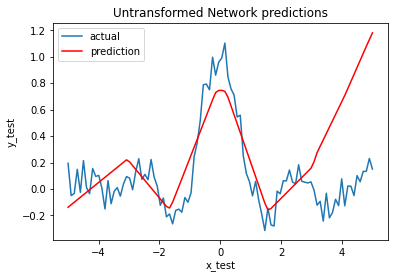

In [9]:
#Set to train mode/enable the train flag
custom_net = custom_net.train()

for epoch in range(epochs):
  #view is equivalent to reshape method
  X = torch.Tensor(train_data.x).view(-1,1)
  Y = torch.Tensor(train_data.y).view(-1,1)
  #sets accumulated gradients to zero so that the delta calculated 
  optimizer.zero_grad()
  prediction = custom_net(X)
  #loss to minimize the difference
  loss_fn_obj = loss_function(prediction, Y) 
  #computes gradient            
  loss_fn_obj.backward()
  optimizer.step()
    
  if epoch % (epochs // 10) == 0:
    print("epoch = %6d" % epoch, end="")
    print(" batch loss = %7.4f\n" % loss_fn_obj.item(), end="")
    #enable_eval mode to monitor accuracy in between
    custom_net.eval()
    rmse = calc_rmse(custom_net, X, Y)
    print("RMSE  = %0.2f" % rmse)
      #re-enable the train mode
    custom_net.train()

custom_net.eval()

x_test = test_data.x
y_test = test_data.y
  
X_test = torch.Tensor(x_test).view(-1,1)
#Picking the model corresponding to the last epoch
Y_dash_test = custom_net(X_test)
Y_dash_test = (Y_dash_test.view(-1))
y_dash_test = Y_dash_test.detach().numpy()
plt.plot(x_test,y_test,label='actual')
plt.plot(x_test,y_dash_test,color='red',label='prediction')
plt.title('Untransformed Network predictions')
plt.xlabel('x_test')
plt.ylabel('y_test')
plt.legend()
plt.show()

In [10]:
#ADF equivalents for Neural Network's building blocks
from numbers import Number
def normcdf(value, mu=0.0, stddev=1.0):
    sinv = (1.0 / stddev) if isinstance(stddev, Number) else stddev.reciprocal()
    return 0.5 * (1.0 + torch.erf((value - mu) * sinv / np.sqrt(2.0)))


def _normal_log_pdf(value, mu, stddev):
    var = (stddev ** 2)
    log_scale = np.log(stddev) if isinstance(stddev, Number) else torch.log(stddev)
    return -((value - mu) ** 2) / (2.0*var) - log_scale - np.log(np.sqrt(2.0*np.pi))


def normpdf(value, mu=0.0, stddev=1.0):
    return torch.exp(_normal_log_pdf(value, mu, stddev))


class adf_relu(nn.Module):
    def __init__(self, keep_variance_fn=None):
        super(adf_relu, self).__init__()
        self._keep_variance_fn = keep_variance_fn

    def forward(self, features_mean, features_variance):
        features_stddev = torch.sqrt(features_variance)
        div = features_mean / features_stddev
        pdf = normpdf(div)
        cdf = normcdf(div)
        outputs_mean = features_mean * cdf + features_stddev * pdf
        outputs_variance = (features_mean ** 2 + features_variance) * cdf \
                           + features_mean * features_stddev * pdf - outputs_mean ** 2
        if self._keep_variance_fn is not None:
            outputs_variance = self._keep_variance_fn(outputs_variance)
        return outputs_mean, outputs_variance

class adf_dropout(nn.Module):
    """ADF implementation of nn.Dropout2d"""
    def __init__(self, p: float = 0.5, keep_variance_fn=None, inplace=False):
        super(adf_dropout, self).__init__()
        self._keep_variance_fn = keep_variance_fn
        self.inplace = inplace
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def forward(self, inputs_mean, inputs_variance):
        if self.training:
            binary_mask = torch.ones_like(inputs_mean)
            binary_mask = tf.dropout2d(binary_mask, self.p, self.training, self.inplace)

            outputs_mean = inputs_mean*binary_mask
            outputs_variance = inputs_variance*binary_mask**2

            if self._keep_variance_fn is not None:
                outputs_variance = self._keep_variance_fn(outputs_variance)
            return outputs_mean, outputs_variance

        outputs_variance = inputs_variance
        if self._keep_variance_fn is not None:
            outputs_variance = self._keep_variance_fn(outputs_variance)
        return inputs_mean, outputs_variance

class adf_linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, keep_variance_fn=None):
        super(adf_linear, self).__init__()
        self._keep_variance_fn = keep_variance_fn
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, inputs_mean, inputs_variance):
        outputs_mean = tf.linear(inputs_mean, self.weight, self.bias)
        outputs_variance = tf.linear(inputs_variance, self.weight**2, None)
        if self._keep_variance_fn is not None:
            outputs_variance = self._keep_variance_fn(outputs_variance)
        return outputs_mean, outputs_variance

In [11]:
class mcdo_adf_net(torch.nn.Module):
  def __init__(self):
    super(mcdo_adf_net, self).__init__()
    #hidden layers
    self.hid1 = adf_linear(1,100)
    self.dropout = adf_dropout(p=0.2)
    self.act_fn = adf_relu()
    #output
    self.output = adf_linear(100,1)
    #initialize weights and with a normal distribution with std = 1(default)
    #zeros resp.
    torch.nn.init.normal_(self.hid1.weight)
    torch.nn.init.zeros_(self.hid1.bias)
    torch.nn.init.normal_(self.output.weight)
    torch.nn.init.zeros_(self.output.bias)
    #can be achieved using nn.Sequential also
  def forward(self, x):
    # define how every layer is linked with each other and how computation 
    #takes place
    #Activation functions
    inputs_mean = x
    inputs_variance = torch.zeros_like(inputs_mean) + 0.20
    x = inputs_mean, inputs_variance
    x_1 = self.hid1(*x)
    
    x_2 = self.act_fn(*x_1)
    inputs_mean, inputs_variance = x_2
    x_3 = self.dropout(*x_2)

    x_4 = self.output(*x_3)
    return x_4

In [12]:
def log_likelihood(y_pred, y_true, sigma):
    y_true = torch.Tensor(y_true)
    y_pred= torch.Tensor(y_pred)
    sigma = torch.Tensor(sigma)
    
    dist = torch.distributions.normal.Normal(loc=y_pred, scale=sigma)
    #print(np.shape(y_true.view(-1)))
    ll = torch.mean(dist.log_prob(y_true))
    ll = np.asscalar(ll.numpy())
    print("NLL = {}".format(-ll))
    return ll


def compute_rmse(predictions, real_values):
    assert np.all(predictions.shape == real_values.shape)
    mse = np.mean(np.square(predictions - real_values))
    rmse = np.sqrt(mse)
    print("RMSE = {}".format(rmse))
    return rmse

def explained_variance_1d(ypred,y):
    """
    Var[ypred - y] / var[y].
    https://www.quora.com/What-is-the-meaning-proportion-of-variance-explained-in-linear-regression
    """
    assert y.ndim == 1 and ypred.ndim == 1
    vary = np.var(y)
    return np.nan if vary==0 else 1 - np.var(y-ypred)/vary


def compute_explained_variance(predictions, real_values):
    """
    Computes the explained variance of prediction for each
    steering and the average of them
    """
    assert np.all(predictions.shape == real_values.shape)
    ex_variance = explained_variance_1d(predictions, real_values)
    print("EVA = {}".format(ex_variance))
    return ex_variance


NLL = 2.284126043319702
RMSE = 0.3796666294359526
EVA = -0.3480527805001272


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  if __name__ == '__main__':


-0.3480527805001272

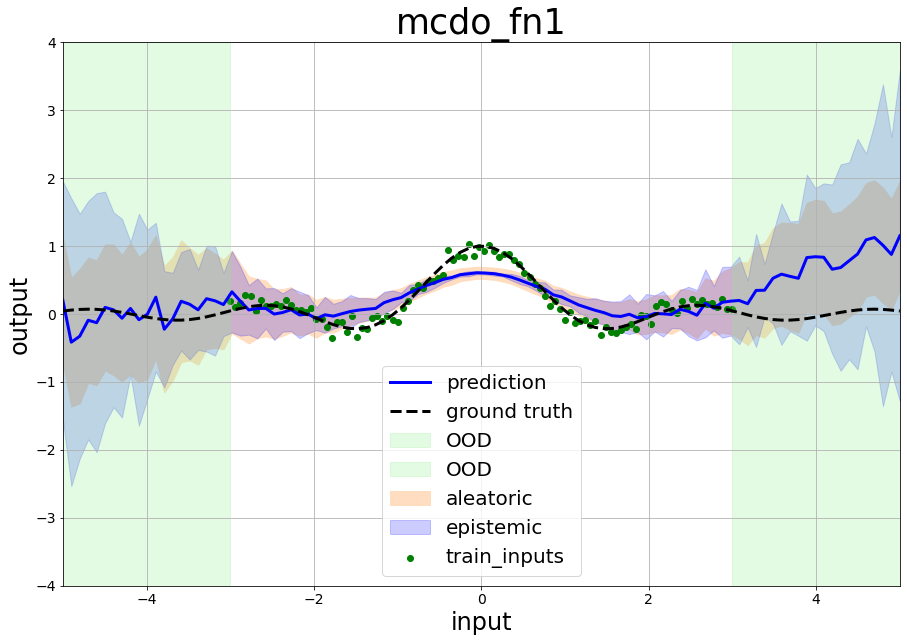

In [13]:
#Inference
mc_sample_count = 20
mcdo_adf_model = mcdo_adf_net()
mcdo_adf_model.load_state_dict(custom_net.state_dict())

mcdo_adf_model.dropout.train()

x_test = test_data.x
y_test = test_data.y
  
X_test = torch.Tensor(x_test).view(-1,1)
#Picking the model corresponding to the last epoch
Y_dash_test = custom_net(X_test)

consol_mc_means = []
consol_mc_vars = []
consol_predictions = []
for sample in X_test:
  mc_samples = [mcdo_adf_model(torch.unsqueeze(sample,0)) for _ in range(mc_sample_count)]
  mc_samples_means = np.array([t[0].view(-1).detach().numpy() for t in mc_samples])
  mc_samples_vars = np.array([t[1].view(-1).detach().numpy() for t in mc_samples])
  consol_mc_means.append(mc_samples_means)
  variances = np.mean(mc_samples_vars, axis=0)
  consol_mc_vars.append(variances)
  pred_means = np.mean(mc_samples_means, axis=0)
  consol_predictions.append(pred_means)

predictions = np.concatenate(consol_predictions, axis=0)


pairwise_mean = np.concatenate(consol_mc_means, axis=1)
epistemic = np.var(pairwise_mean, axis=0)

aleatoric = np.concatenate(consol_mc_vars, axis=0)


plot_results(train_data,test_data, predictions.reshape(-1,1),\
             aleatoric.reshape(-1,1), epistemic.reshape(-1,1),\
              limits={"x":(-5,5),"y":(-4,4)},v_span=[(-5,-3),(3,5)],
             fn_samples=None, legend_loc='lower center',
             title='mcdo_fn1',filename='fn1.pdf')


predictive_uncertainty = epistemic + aleatoric
log_likelihood(predictions.squeeze(), test_data.y_gt.squeeze(), \
               np.sqrt(predictive_uncertainty).squeeze())
compute_rmse(predictions.squeeze(),test_data.y_gt.squeeze())
compute_explained_variance(predictions.squeeze(), test_data.y_gt.squeeze())